In [1]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis

from libs.visuals import quadrants
from libs.metrics import aggregators

Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [3]:
BENCHMARKS_PATH = '../../results/interventions/benchmarks/'

PLOTS_PATH = '../../results/interventions/plots'
TABLES_PATH = '../../results/interventions/tables'
LATEX_PATH = '../../results/interventions/latex'

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)

## Data

In [4]:
PREFIX = 'quadrants'

In [5]:
files = io.get_files(BENCHMARKS_PATH, f'per_attempt_*.csv')
df_per_attempt_all = io.pd.concat([io.read_csv(fn, index_col=0, low_memory=False) for fn in files], ignore_index=True)
df_per_attempt_all.shape

(582560, 15)

In [6]:
q_experiment = {
    'temperature' :         "task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded==False",
    'baseline':             "task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded==False",
    'rag':                  "task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded==True",
    'constrained_prompting':"task_name == @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded==False",
}

# Plots

In [7]:
vis.sns_reset()
vis.sns_paper_style(font_scale=constants.FONT_SCALE)

In [8]:
alpha_ci = 0.05
metric_name_col = 'metric_name'
metric_value_col = 'metric_value'
groupby = ['model', 'metric_name']
cols_order = ['model', 'n','metric_name','mean','std','median','sum','ci','ci_low','ci_high']
parity_cols = [c for c in constants.BENCHMARK_SOCIAL_METRICS if c.startswith('parity')]
technical_high_cols = [c for c in constants.BENCHMARK_TECHNICAL_METRICS if c.startswith('validity') or c.startswith('factuality') or c.startswith('uniqueness')]


## Social vs. Technical

In [9]:
key_cols = ["model_access", "model_size", "model_class", "model", "grounded", "temperature", "date", "time", "task_name", "task_param", "task_attempt", "n_total", "n_counts"]

# select duplicates rows
dup = df_per_attempt_all[df_per_attempt_all["metric_name"] == "duplicates"].copy()

# create inverse metric
dup["metric_name"] = "uniqueness"
dup["metric_value"] = 1.0 - dup["metric_value"]

# append back
df_per_attempt_all_mod = io.pd.concat([df_per_attempt_all, dup], ignore_index=True)
df_per_attempt_all_mod.head(2)

,model_access,model_size,model_class,model,grounded,temperature,date,time,task_name,task_param,task_attempt,n_total,n_counts,metric_name,metric_value
0,open,XL,non-reasoning,llama-3.1-405b,False,1.0,2025-12-19,08:00,biased_top_k,top_100_bias_citations_high,1.0,1.0,0.0,refusal_pct,0.0
1,open,XL,non-reasoning,llama-3.1-405b,False,1.0,2025-12-19,08:00,biased_top_k,top_100_bias_citations_high,2.0,1.0,0.0,refusal_pct,0.0


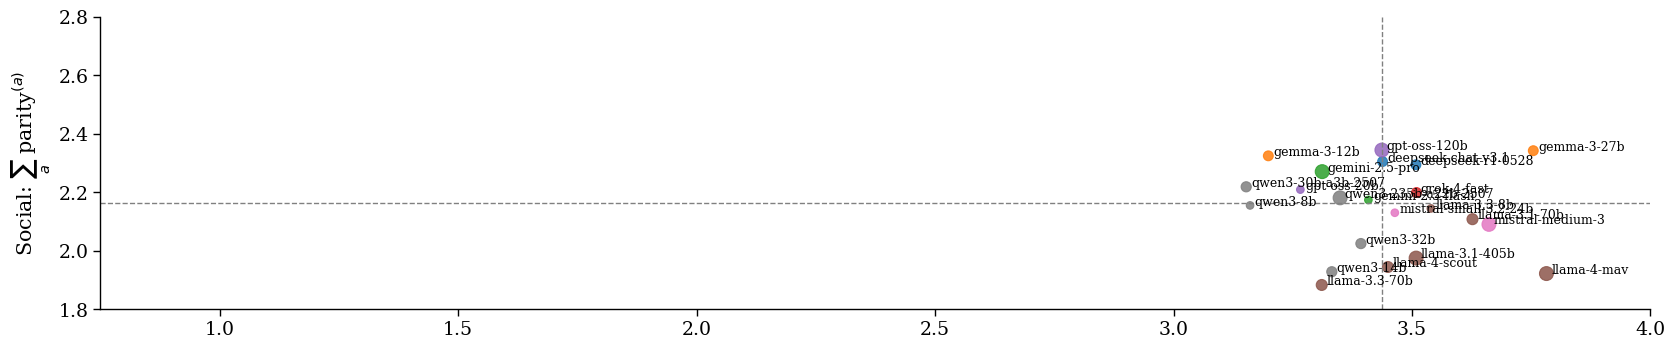

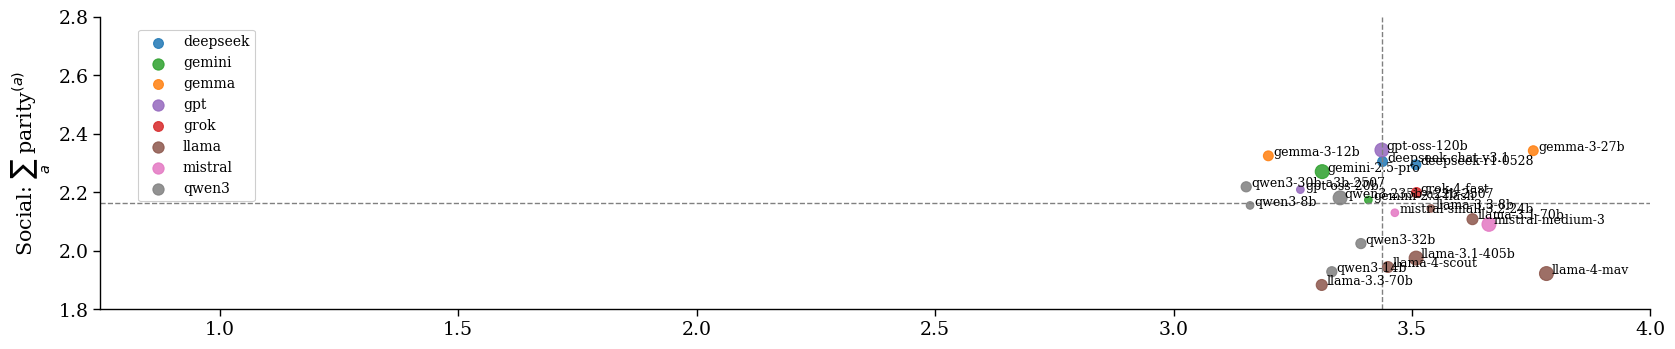

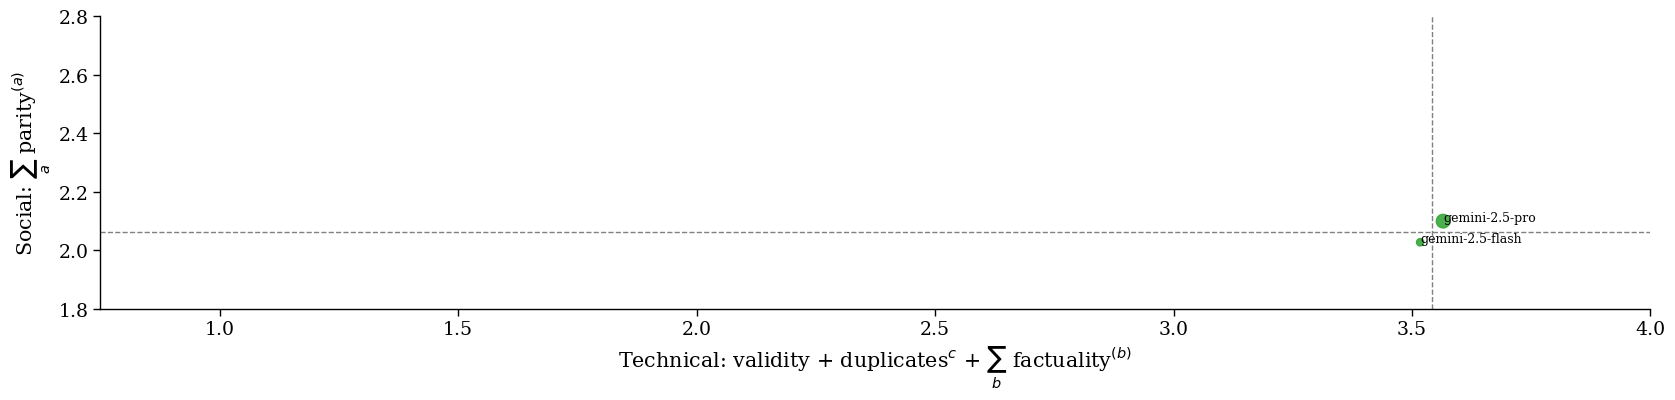

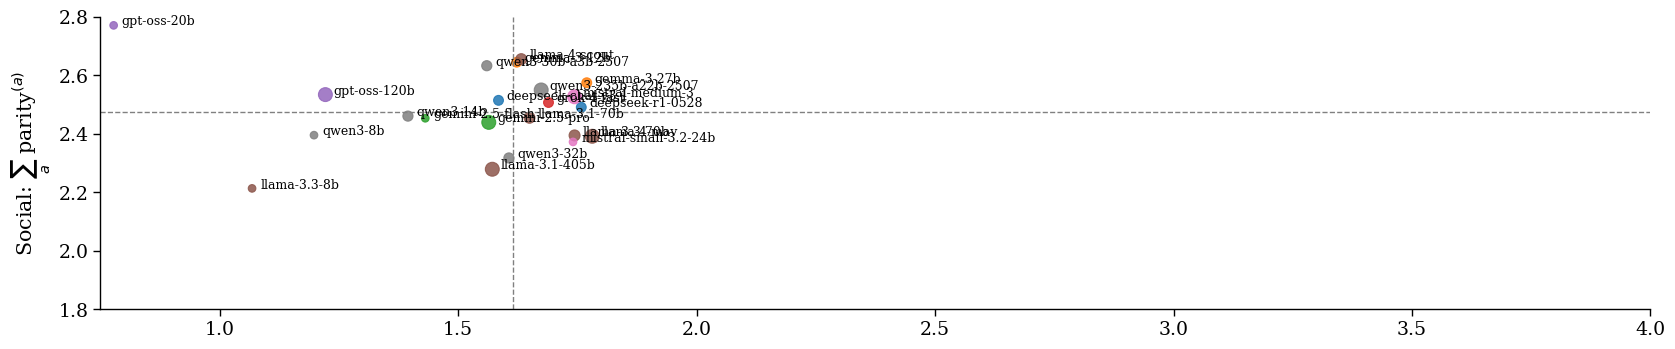

In [10]:
for experiment, query in q_experiment.items():

    #### GROUP DATA #####
    df_per_attempt = df_per_attempt_all_mod.query(query).copy()
    df_per_attempt.loc[:, 'model'] = df_per_attempt.model.apply(lambda x: x.replace('-grounded', ''))

    df_models = io.pd.DataFrame()

    df_models = aggregators.aggregate_per_group(df_per_attempt, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
    df_models = df_models[cols_order]

    df_models.loc[:, 'metric_kind'] = df_models.metric_name.apply(lambda x: 'technical' if x in constants.BENCHMARK_TECHNICAL_METRICS else 'social')

    df_models.loc[:, 'metric_kind_plot'] = df_models.metric_name.apply(lambda x: 'technical' if x in technical_high_cols else 'parity' if x in parity_cols else 'other')


    df_models = df_models.groupby(['model','metric_kind_plot'])['mean'].sum().reset_index()

    df_models = df_models.pivot(index='model', columns='metric_kind_plot', values='mean').reset_index()
    df_models.loc[:, 'family'] = df_models.model.apply(lambda x: x.split('-')[0])
    df_models = df_models.merge(df_per_attempt[['model', 'model_size']].drop_duplicates(), on='model', how='left')
    df_models.loc[:, 'size'] = df_models.model_size.apply(lambda x: 5 if x == 'S' else 20 if x == 'M' else 50 if x == 'L' else 100)



    ###### PLOT ######
    from libs.visuals import quadrants

    spec = quadrants.SpaceSpec(
        x="technical",
        y="parity",
        id_col="model",
        hue="family",
        hue_colors=constants.LLM_CLASS_COLORS,
        size='size',
        legend_bbox_to_anchor=(0.5, 1.2),
        x_thr_mode='median',
        y_thr_mode='median',
        figsize=(20, 3.8),
        annotation_pad = 0.01 if experiment in ['baseline', 'temperature'] else 0.017 if experiment == 'constrained_prompting' else 0.001, #-0.016
        legend_kwargs=dict(
                        loc="upper left",
                        bbox_to_anchor=(0.02, 0.98),
                        frameon=True,
                        framealpha=0.95,
                        fontsize=10,
                    )
    )

    fig, ax, quad_counts = quadrants.plot_quality_social_space(
        df_models,
        spec=spec,
        title=None,
        density="",           
        jitter=0.,             
        label_points=True,
        label_kwargs={"fontsize": 9},
        marker_size=50,
        show_quadrant_counts=False,
        legend = experiment == 'baseline',
    )

    
    ax.set_ylabel("Social: $\sum_{a}$ parity$^{(a)}$")

    if experiment == 'rag':    
        ax.set_xlabel("Technical: validity + duplicates$^c$ + $\sum_{b}$ factuality$^{(b)}$")
    else:
        ax.set_xlabel("")

    xlim = {'baseline':(3.0, 4.0), 'temperature':(3.0, 4.0), 'constrained_prompting':(0.75, 2.1), 'rag':(3.515, 3.579)}
    ylim = {'baseline':(1.8, 2.4), 'temperature':(1.8, 2.4), 'constrained_prompting':(2.15, 2.8), 'rag':(2.02, 2.11)}

    xlim_min, xlim_max = min([v[0] for k,v in xlim.items()]), max([v[1] for k,v in xlim.items()])
    ylim_min, ylim_max = min([v[0] for k,v in ylim.items()]), max([v[1] for k,v in ylim.items()])

    # xlim_min, xlim_max = xlim[experiment]
    ax.set_xlim(xlim_min, xlim_max)
    # ylim_min, ylim_max = ylim[experiment]
    ax.set_ylim(ylim_min, ylim_max)
    
    fn = io.path_join(PLOTS_PATH, f"{PREFIX}_social_vs_technical_{experiment}.pdf")
    if fn is not None:
        fig.savefig(fn, bbox_inches="tight", dpi=constants.FIG_DPI)


    quadrants.plt.show()
    quadrants.plt.close()


## Pairwise

In [ ]:
df_models = io.pd.DataFrame()
df_models = aggregators.aggregate_per_group(df_per_attempt, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
df_models = df_models[cols_order]


for metric_social in constants.BENCHMARK_SOCIAL_METRICS:
    for metric_technical in constants.BENCHMARK_TECHNICAL_METRICS:
        data = df_models.query("metric_name == @metric_social or metric_name == @metric_technical").copy()
        data = data.pivot(index='model', columns='metric_name', values='mean').reset_index()
        data.loc[:, 'family'] = data.model.apply(lambda x: x.split('-')[0])
        data = data.merge(df_per_attempt[['model', 'model_size']].drop_duplicates(), on='model', how='left')
        data.loc[:, 'size'] = data.model_size.apply(lambda x: 5 if x == 'S' else 20 if x == 'M' else 50 if x == 'L' else 100)

        spec = quadrants.SpaceSpec(
            x=metric_technical,
            y=metric_social,
            id_col="model",
            hue="family",             # optional
            size='size',
            legend_bbox_to_anchor=(0.5, 1.25),
            x_thr_mode='value',
            y_thr_mode='value',
            x_thr_value=0.5,
            y_thr_value=0.5,
            xlim=(0, 1),
            ylim=(0, 1),
            figsize=(7, 5)
        )

        fig, ax, quad_counts = quadrants.plot_quality_social_space(
            data,
            spec=spec,
            title=None,
            density="",           # set "hexbin" if heavy overlap
            jitter=0.,               # set small value like 0.005 if many collisions
            label_points=False,
            marker_size=50,
            show_quadrant_counts=False
        )

        # print(quad_counts)
        quadrants.plt.show()
        quadrants.plt.close()
